# Randomized SVD: 
# Using Randomness to Speed Up Code

**Our goal today**: ![background removal](images/surveillance3.png)

## Load and Format the Data

Let's use the real video 003 dataset from [BMC 2012 Background Models Challenge Dataset](http://bmc.iut-auvergne.com/?page_id=24)

Import needed libraries:

In [1]:
import moviepy.editor as mpe
import numpy as np
import scipy

%matplotlib inline
import matplotlib.pyplot as plt

In [147]:
video = mpe.VideoFileClip("videos/Video_003.avi")

In [3]:
video.subclip(0,50).ipython_display(width=300)

100%|█████████▉| 350/351 [00:00<00:00, 995.05it/s]


In [4]:
video.duration

113.57

### Helper Methods

In [5]:
def create_data_matrix_from_video(clip, k=5, scale=50):
    return np.vstack([scipy.misc.imresize(rgb2gray(clip.get_frame(i/float(k))).astype(int), 
                      scale).flatten() for i in range(k * int(clip.duration))]).T

In [6]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

### Format the Data

An image from 1 moment in time is 60 pixels by 80 pixels (when scaled). We can *unroll* that picture into a single tall column. So instead of having a 2D picture that is $60 \times 80$, we have a $1 \times 4,800$ column 

This isn't very human-readable, but it's handy because it lets us stack the images from different times on top of one another, to put a video all into 1 matrix.  If we took the video image every tenth of a second for 113 seconds (so 11,300 different images, each from a different point in time), we'd have a $11300 \times 4800$ matrix, representing the video! 

In [143]:
scale = 0.50   # Adjust scale to change resolution of image
dims = (int(240 * scale), int(320 * scale))

In [148]:
M = create_data_matrix_from_video(video, 100, scale)
#M = np.load("low_res_surveillance_matrix.npy")

In [145]:
print(dims, M.shape)

(120, 160) (19200, 7900)


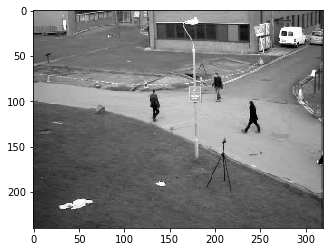

In [15]:
plt.imshow(np.reshape(M[:,140], dims), cmap='gray');

Since `create_data_from_matrix` is somewhat slow, we will save our matrix.  In general, whenever you have slow pre-processing steps, it's a good idea to save the results for future use.

In [19]:
np.save("high_res_surveillance_matrix.npy", M)

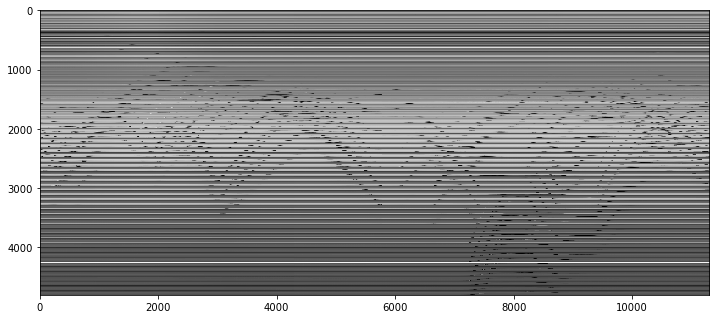

In [33]:
plt.figure(figsize=(12, 12))
plt.imshow(M, cmap='gray')

**Questions**: What are those wavy black lines?  What are the horizontal lines?

#### Pretty Pictures

In [21]:
U, s, V = fbpca.pca(M, 10)

In [22]:
reconstructed_matrix = U[:,:2] @ np.diag(s[:2]) @ V[:2,:]

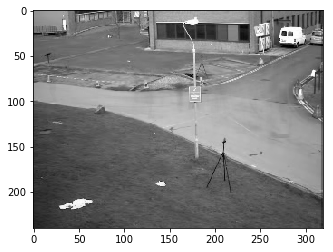

In [23]:
plt.imshow(np.reshape(reconstructed_matrix[:,140], dims), cmap='gray');

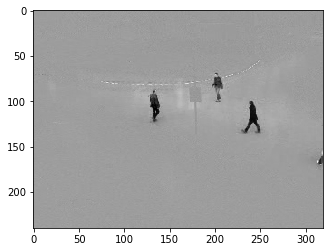

In [24]:
plt.imshow(np.reshape(M[:,140] - reconstructed_matrix[:,140], dims), cmap='gray');

## SVD

In [11]:
U, s, V = np.linalg.svd(M, full_matrices=False)

What do $U$, $S$, and $V$ look like?

In [12]:
U.shape, s.shape, V.shape

((4800, 4800), (4800,), (4800, 11300))

In [15]:
np.set_printoptions(suppress=True, precision=4)

Do you see anything about the order for $s$?

In [51]:
s[0:1200:50]

array([ 915871.4421,    6738.7947,    3777.6036,    2455.4399,
          1715.12  ,    1256.1567,    1004.9143,     801.0167,
           646.76  ,     525.8728,     430.989 ,     351.2931,
           284.7594,     226.91  ,     176.9419,     126.8077,
             0.    ,       0.    ,       0.    ,       0.    ,
             0.    ,       0.    ,       0.    ,       0.    ])

In [47]:
s[1000]

9.1506400268165497e-11

$U$ is a giant matrix, so let's just look at a tiny bit of it:

In [32]:
U[:5,:5]

array([[-0.0168, -0.0022, -0.0016,  0.0053, -0.0003],
       [-0.017 , -0.003 , -0.0003,  0.0066, -0.0008],
       [-0.0174, -0.0031, -0.001 ,  0.0062, -0.0013],
       [-0.0178, -0.003 , -0.0006,  0.0065, -0.0016],
       [-0.0181, -0.0029, -0.0012,  0.0066, -0.0017]])

The size of each column and each row of $U$ is 1

In [33]:
np.linalg.norm(U[:, 100]), np.linalg.norm(U[100, :])

(1.0000000000000004, 0.99999999999999989)

The size of each row of $V$ is 1

In [34]:
np.linalg.norm(V[:, 100])

1.0

Check that they are a decomposition of M

In [16]:
reconstructed_matrix = u @ np.diag(s) @ v

In [17]:
np.allclose(M, reconstructed_matrix)

True

They are! :-)

### Finding the background

In [22]:
U.shape, s.shape, V.shape

((4800, 4800), (4800,), (4800, 11300))

In [38]:
low_rank = np.expand_dims(U[:,0], 1) * s[0] * np.expand_dims(V[0,:], 0)

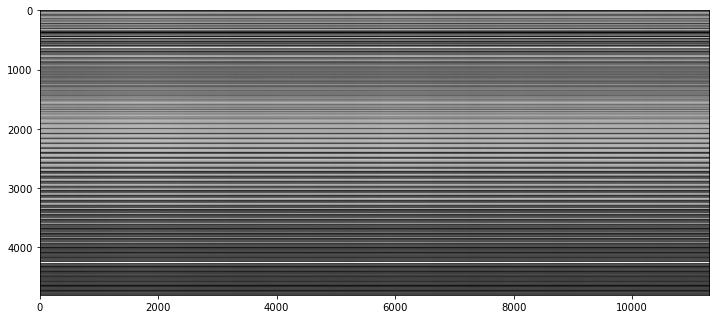

In [39]:
plt.figure(figsize=(12, 12))
plt.imshow(low_rank, cmap='gray')

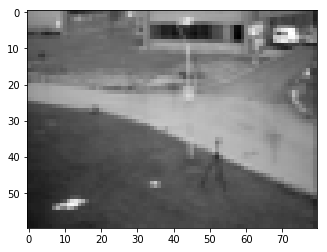

In [40]:
plt.imshow(np.reshape(low_rank[:,0], dims), cmap='gray');

How do we get the people from here?

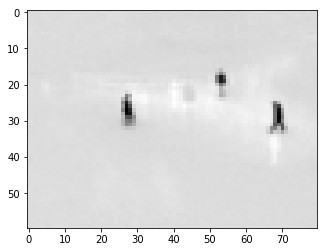

In [41]:
plt.imshow(np.reshape(M[:,0] - low_rank[:,0], dims), cmap='gray');

High-resolution version

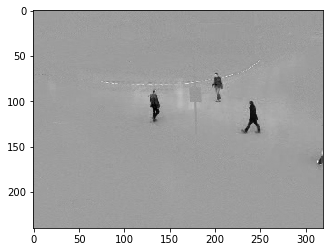

In [35]:
plt.imshow(np.reshape(M[:,140] - low_rank[:,140], dims), cmap='gray');

### Aside about data compression

Suppose we take 800 singular values (remember, there are 4800 singular values total)

In [53]:
s[0:1000:50]

array([ 915871.4421,    6738.7947,    3777.6036,    2455.4399,
          1715.12  ,    1256.1567,    1004.9143,     801.0167,
           646.76  ,     525.8728,     430.989 ,     351.2931,
           284.7594,     226.91  ,     176.9419,     126.8077,
             0.    ,       0.    ,       0.    ,       0.    ])

In [65]:
k = 800
compressed_M = U[:,:k] @ np.diag(s[:k]) @ V[:k,:]

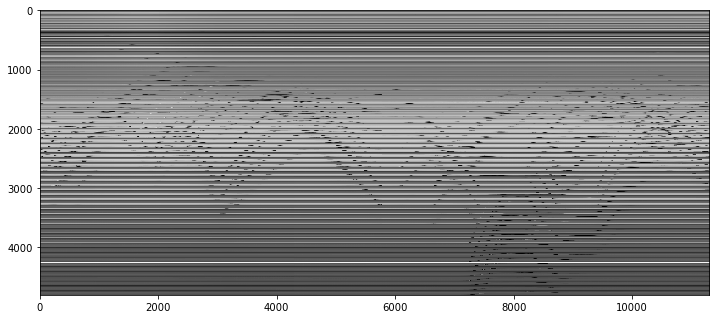

In [66]:
plt.figure(figsize=(12, 12))
plt.imshow(compressed_M, cmap='gray')

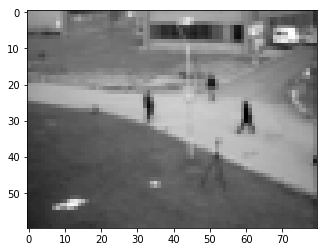

In [67]:
plt.imshow(np.reshape(compressed_M[:,140], dims), cmap='gray');

In [68]:
np.allclose(compressed_M, M)

True

In [69]:
U[:,:k].shape, s[:k].shape, V[:k,:].shape

((4800, 800), (800,), (800, 11300))

space saved = data in U, s, V for 800 singular values / original matrix

In [71]:
((4800 + 1 + 11300) * 800) / (4800 * 11300)

0.2374778761061947

We only need to store 23.7% as much data and can keep the accuracy to 1e-5!  That's great!

### Other data sets

In [118]:
video2 = mpe.VideoFileClip("videos/Video_008.avi")

In [69]:
video.duration

79.3

In [71]:
video.subclip(0,10).ipython_display(width=300)

 99%|█████████▉| 100/101 [00:00<00:00, 685.63it/s]


In [83]:
v = video.get_frame(10)

In [84]:
v.shape

(240, 320, 3)

In [123]:
scale = 0.5   # Adjust scale to change resolution of image
dims = (int(240 * scale), int(320 * scale))

In [124]:
N = create_data_matrix_from_video(video2, 100, scale)
# N = np.load("low_res_traffic_matrix.npy")

In [125]:
N.shape

(19200, 7900)

#### What is my bug?

In [ ]:
def create_data_matrix_from_video(clip, k=5, scale=50):
    return np.vstack([scipy.misc.imresize(rgb2gray(clip.get_frame(i/float(k))).astype(int), 
                      scale).flatten() for i in range(k * int(clip.duration))]).T

In [96]:
video.duration * 100

7930.0

In [91]:
test = video.get_frame(1/float(100))

In [94]:
test2 = rgb2gray(test).astype(int); test2.shape

(240, 320)

In [110]:
test3 = scipy.misc.imresize(test2, 1).flatten()

In [111]:
test3.shape

(6,)

In [99]:
k = 20

In [105]:
test3 = [scipy.misc.imresize(10 for i in range(k * int(video.duration))]

SyntaxError: invalid syntax (<ipython-input-105-2fa89d80f127>, line 1)

In [102]:
len(test3)

1580

In [103]:
test3[0].shape

(6,)

In [104]:
k * int(video.duration)

1580

In [89]:
print(dims, N.shape)

(240, 320) (6, 7900)


In [90]:
print(scale)

1


In [80]:
np.save("high_res_traffic_matrix.npy", N)

In [85]:
240*320

76800

In [81]:
plt.imshow(np.reshape(N[:,340], dims), cmap='gray');

ValueError: cannot reshape array of size 6 into shape (240,320)

#### End

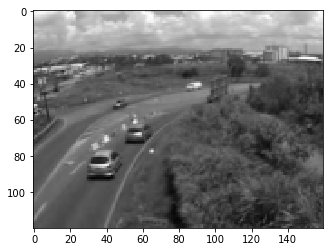

In [126]:
plt.imshow(np.reshape(N[:,340], dims), cmap='gray');

In [137]:
import fbpca

In [139]:
# rand_matrix, smaller_matrix, U, s, V = randomized_svd(N, 2)

U, s, V = fbpca.pca(N, 2)

In [140]:
reconstructed = U @ np.diag(s) @ V; reconstructed.shape

(19200, 7900)

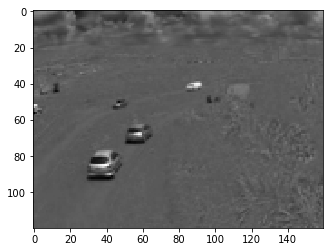

In [142]:
plt.imshow(np.reshape((N - reconstructed)[:, 340], dims), cmap='gray')

### Shuffle together

In [149]:
M.shape, N.shape

((19200, 11300), (19200, 7900))

In [153]:
together = np.hstack((M, N))

In [158]:
shuffled = together[:, np.random.permutation(together.shape[1])]

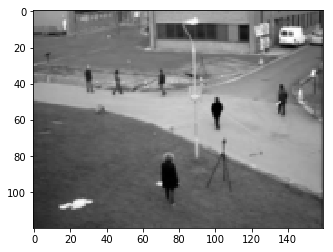

In [159]:
plt.imshow(np.reshape(shuffled[:, 11340], dims), cmap='gray')

In [171]:
# rand_matrix, smaller_matrix, U, s, V = randomized_svd(N, 2)

U, s, V = fbpca.pca(shuffled, 10)

In [172]:
reconstructed = U @ np.diag(s) @ V; reconstructed.shape

(19200, 19200)

In [173]:
U.shape, s.shape, V.shape

((19200, 10), (10,), (10, 19200))

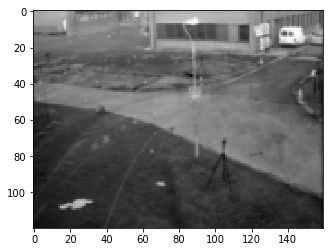

In [174]:
plt.imshow(np.reshape(U[:,0], dims), cmap='gray')

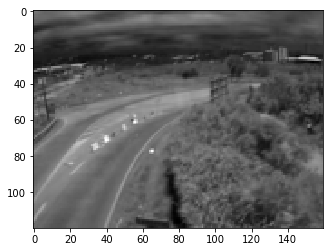

In [176]:
plt.imshow(np.reshape(U[:,2], dims), cmap='gray')

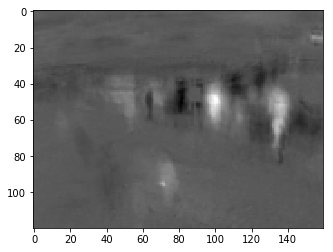

In [180]:
plt.imshow(np.reshape(U[:,6], dims), cmap='gray')

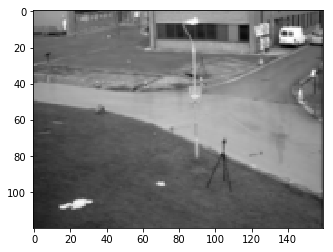

In [164]:
plt.imshow(np.reshape(reconstructed[:, 1], dims), cmap='gray')

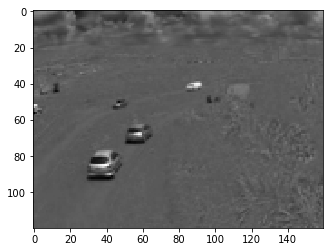

In [142]:
plt.imshow(np.reshape((N - reconstructed)[:, 340], dims), cmap='gray')

### Now back to our background removal problem:

### That's pretty neat!!! but...

**Downside: this was really slow (also, we threw away a lot of our calculation)**

In [12]:
%time u, s, v = np.linalg.svd(M, full_matrices=False)

CPU times: user 4min 3s, sys: 26.7 s, total: 4min 30s
Wall time: 45.8 s


In [47]:
M.shape

(4800, 11300)

#### Let's create a smaller version of M

In [31]:
def randomized_svd(M, k=10):
    m, n = M.shape
    transpose = False
    if m < n:
        transpose = True
        M = M.T
        
    rand_matrix = np.random.normal(size=(M.shape[1], k))  # short side by k
    Q, _ = np.linalg.qr(M @ rand_matrix, mode='reduced')  # long side by k
    smaller_matrix = Q.T @ M                              # k by short side
    U_hat, s, V = np.linalg.svd(smaller_matrix, full_matrices=False)
    U = Q @ U_hat
    
    if transpose:
        return rand_matrix, smaller_matrix, V.T, s.T, U.T
    else:
        return rand_matrix, smaller_matrix, U, s, V

In [12]:
%time u, s, v = randomized_svd(M)

CPU times: user 1.11 s, sys: 140 ms, total: 1.25 s
Wall time: 344 ms


In [33]:
rand_matrix, smaller_matrix, U, s, V = randomized_svd(M, 2)

#### What this method is doing

In [48]:
M = M.T

In [50]:
rand_matrix = np.random.normal(size=(M.shape[1], 2))

In [51]:
rand_matrix.shape

(4800, 2)

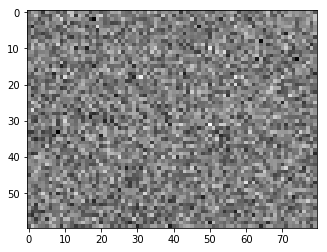

In [52]:
plt.imshow(np.reshape(rand_matrix[:,0], dims), cmap='gray');

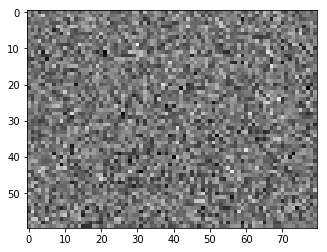

In [53]:
plt.imshow(np.reshape(rand_matrix[:,1], dims), cmap='gray');

In [55]:
temp = M @ rand_matrix; temp.shape

(11300, 2)

In [58]:
np.dot(temp[:,0], temp[:,1])

-832474902758.38965

In [56]:
Q, _ = np.linalg.qr(M @ rand_matrix, mode='reduced'); Q.shape

(11300, 2)

In [57]:
np.dot(Q[:,0], Q[:,1])

2.0816681711721685e-17

In [61]:
smaller_matrix = Q.T @ M; smaller_matrix.shape

(2, 4800)

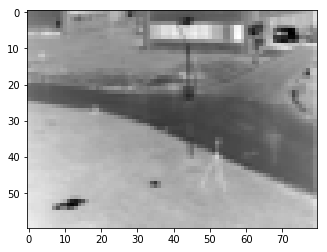

In [63]:
plt.imshow(np.reshape(smaller_matrix[0,:], dims), cmap='gray');

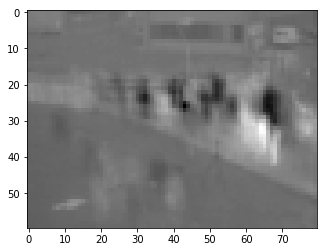

In [64]:
plt.imshow(np.reshape(smaller_matrix[1,:], dims), cmap='gray');

#### How this is different from random mean

In [44]:
test = M @ np.random.normal(size=(M.shape[1], 2)); test.shape

(4800, 2)

Random mean:

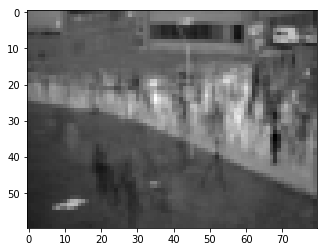

In [45]:
plt.imshow(np.reshape(test[:,0], dims), cmap='gray');

Mean image:

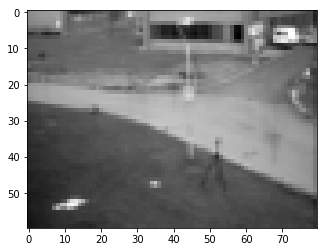

In [46]:
plt.imshow(np.reshape(M.mean(axis=1), dims), cmap='gray')

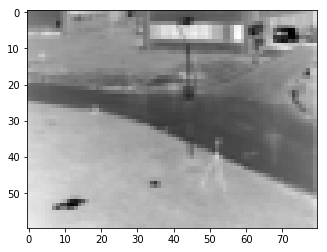

In [41]:
plt.imshow(np.reshape(test[:,1], dims), cmap='gray');

In [42]:
ut, st, vt = np.linalg.svd(test, full_matrices=False)

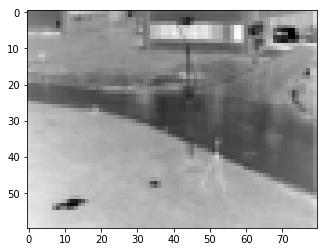

In [28]:
plt.imshow(np.reshape(smaller_matrix[0,:], dims), cmap='gray');

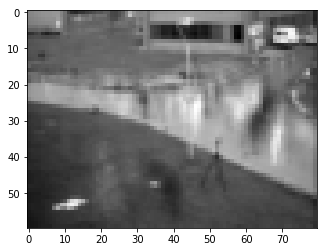

In [29]:
plt.imshow(np.reshape(smaller_matrix[1,:], dims), cmap='gray');

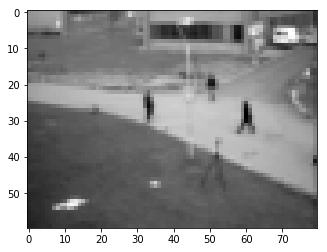

In [30]:
plt.imshow(np.reshape(M[:,140], dims), cmap='gray');

#### Timing Comparison

In [112]:
from sklearn import decomposition
import fbpca

Full SVD:

In [12]:
%time u, s, v = np.linalg.svd(M, full_matrices=False)

CPU times: user 4min 3s, sys: 26.7 s, total: 4min 30s
Wall time: 45.8 s


Our (highly simplified) randomized_svd from above:

In [15]:
%time u, s, v = randomized_svd(M, 10)

CPU times: user 936 ms, sys: 88 ms, total: 1.02 s
Wall time: 237 ms


Scikit learn:

In [14]:
%time u, s, v = decomposition.randomized_svd(M, 10)

CPU times: user 12.6 s, sys: 880 ms, total: 13.4 s
Wall time: 2.4 s


Randomized SVD from Facebook's library fbpca:

In [16]:
%time u, s, v = fbpca.pca(M, 10)

CPU times: user 3.49 s, sys: 264 ms, total: 3.75 s
Wall time: 757 ms


I would choose this once, since it's faster than sklearn but more robust and more accurate than ours.

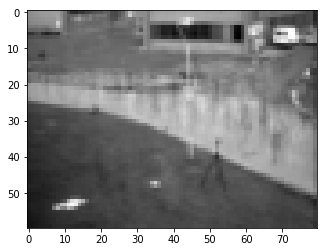

In [258]:
plt.imshow(np.reshape(reconstructed_small_M[:,0], dims), cmap='gray');

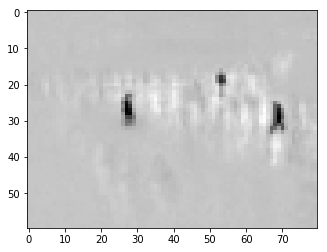

In [259]:
plt.imshow(np.reshape(M[:,0] - reconstructed_small_M[:,0], dims), cmap='gray');

In [310]:
%time U_r, s_r, V_r = randomized_svd(M, k=800)

CPU times: user 21.6 s, sys: 7.05 s, total: 28.6 s
Wall time: 10.5 s


In [307]:
# U, s, V = np.linalg.svd(M, full_matrices=False)
U_r, s_r, V_r = randomized_svd(M, k=800)

In [308]:
reconstructed_small_M = U_r @ np.diag(s_r) @ V_r

In [309]:
np.max(np.linalg.norm(reconstructed_small_M - M))

6.5392844963297777e-09

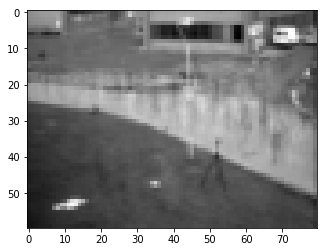

In [258]:
plt.imshow(np.reshape(reconstructed_small_M[:,0], dims), cmap='gray');

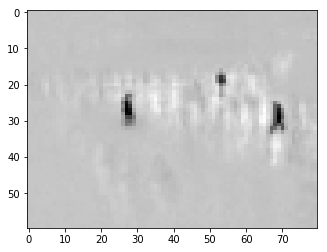

In [259]:
plt.imshow(np.reshape(M[:,0] - reconstructed_small_M[:,0], dims), cmap='gray');

### Details

#### Process behind Randomized SVD

Here is a process to calculate a truncated SVD, described in [Finding Structure with Randomness: Probabilistic Algorithms for Constructing Approximate Matrix Decompositions](https://arxiv.org/pdf/0909.4061.pdf) and [summarized in this blog post](https://research.fb.com/fast-randomized-svd/):

1\. Compute an approximation to the range of $A$. That is, we want $Q$ with $r$ orthonormal columns such that $$A \approx QQ^TA$$


2\. Construct $B = Q^T A$, which is small ($r\times n$)


3\. Compute the SVD of $B$ by standard methods (fast since $B$ is smaller than $A$), $B = S\,\Sigma V^T$

4\. Since $$ A \approx Q Q^T A = Q (S\,\Sigma V^T)$$ if we set $U = QS$, then we have a low rank approximation $A \approx U \Sigma V^T$.

#### So how do we find $Q$ (in step 1)?

To estimate the range of $A$, we can just take a bunch of random vectors $w_i$, evaluate the subspace formed by $Aw_i$.  We can form a matrix $W$ with the $w_i$ as it's columns.  Now, we take the QR decomposition of $AW = QR$, then the columns of $Q$ form an orthonormal basis for $AW$, which is the range of $A$.

Since the matrix $AW$ of the product has far more rows than columns and therefore, approximately, orthonormal columns. This is simple probability - with lots of rows, and few columns, it's unlikely that the columns are linearly dependent.

#### Why M ~ Q Q.T M

We are trying to find a matrix Q such that $M \approx Q Q^T M$.  We are interested in the range of $M$, let's call this $MX$.  $Q$ has orthonormal columns so $Q^TQ = I$ (but $QQ^T$ isn't $I$, since $Q$ is rectangular)

$$ QR = MX $$
$$ QQ^TQR = QQ^TMX $$
$$ QR = QQ^TMX $$
so...
$$ MX = QQ^TMX $$

If $X$ is the identity, we'd be done (but then $X$ would be too big, and we wouldn't get the speed up we're looking for).  In our problem, $X$ is just a small random matrix.  The Johnson-Lindenstrauss Lemma provides some justification of why this works.

#### The QR Decomposition

We will be learning about the QR decomposition **in depth** later on.  For now, you just need to know that $A = QR$, where $Q$ consists of orthonormal columns, and $R$ is upper triangular.  Trefethen says that the QR decomposition is the most important idea in numerical linear algebra!  We will definitely be returning to it.

#### How should we choose $r$?

Suppose our matrix has 100 columns, and we want 5 columns in U and V. To be safe, we should project our matrix onto an orthogonal basis with a few more rows and columns than 5 (let's use 15).  At the end, we will just grab the first 5 columns of U and V

So even although our projection was only approximate, by making it a bit bigger than we need, we can make up for the loss of accuracy (since we're only taking a subset later). 

The runtime complexity for SVD is $\mathcal{O}(\text{min}(m^2 n,\; m n^2))$

### Accuracy as you increase # of singular values

In [248]:
step = 20
n = 20
error = np.zeros(n)

for i in range(n):
    U, s, V = randomized_svd(vectors, i * step)
    reconstructed = U @ np.diag(s) @ V
    error[i] = np.linalg.norm(vectors - reconstructed)

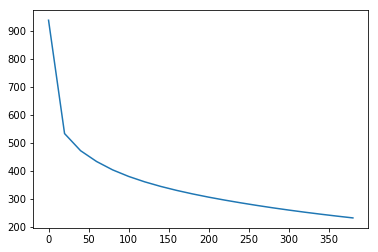

In [242]:
plt.plot(range(0,n*step,step), error)

**Idea**: Let's use a smaller matrix (with smaller $n$)!

Instead of calculating the SVD on our full matrix $A$ which is $m \times n$, let's use $B = A Q$, which is just $m \times r$ and $r << n$

We haven't found a better general SVD method, we are just using the method we have on a smaller matrix.

Here are some results from [Facebook Research](https://research.fb.com/fast-randomized-svd/):

<img src="images/randomizedSVDbenchmarks.png" alt="" style="width: 80%"/>

**Johnson-Lindenstrauss Lemma**: ([from wikipedia](https://en.wikipedia.org/wiki/Johnson%E2%80%93Lindenstrauss_lemma)) a small set of points in a high-dimensional space can be embedded into a space of much lower dimension in such a way that distances between the points are nearly preserved.

It is desirable to be able to reduce dimensionality of data in a way that preserves relevant structure. The Johnson–Lindenstrauss lemma is a classic result of this type.

**Further Resources**:
- [a whole course on randomized algorithms](http://www.cs.ubc.ca/~nickhar/W12/)

### A first attempt with SVD

Let's zoom in on the people:

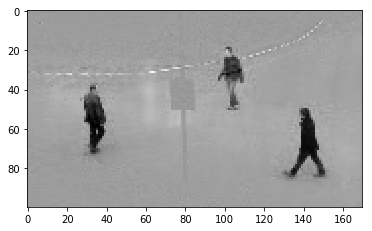

In [36]:
plt.imshow(np.reshape(M[:,140] - low_rank[:,140], dims)[50:150,100:270], cmap='gray');

This is amazing for such a simple approach!  We get somewhat better results through a more complicated algorithm below.

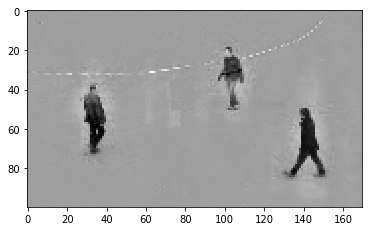

In [33]:
plt.imshow(np.reshape(S[:,140], dims)[50:150,100:270], cmap='gray')

- **Topic Modeling** (NMF and SVD.  SVD uses QR)  A group of documents can be represented by a term-document matrix
<img src="images/document_term.png" alt="term-document matrix" style="width: 70%"/>
  (source: [Introduction to Information Retrieval](http://player.slideplayer.com/15/4528582/#))
<img src="images/nmf_doc.png" alt="NMF on documents" style="width: 70%"/>
  (source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

Images can be represented by matrices.

<img src="images/digit.gif" alt="digit" style="width: 55%"/>
  (Source: [Adam Geitgey
](https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721))


Topic modeling is a great way to get started with matrix factorizations. We start with a **term-document matrix**:

<img src="images/document_term.png" alt="term-document matrix" style="width: 80%"/>
(source: [Introduction to Information Retrieval](http://player.slideplayer.com/15/4528582/#))

We can decompose this into one tall thin matrix times one wide short matrix (possibly with a diagonal matrix in between).

Notice that this representation does not take into account word order or sentence structure.  It's an example of a **bag of words** approach.

It's rare that we need to do highly accurate matrix computations at scale. In fact, often we're doing some kind of machine learning, and less accurate approaches can prevent overfitting.

If we accept some decrease in accuracy, then we can often increase speed by orders of magnitude (and/or decrease memory use) by using approximate algorithms. These algorithms typically give a correct answer with some probability. By rerunning the algorithm multiple times you can generally increase that probability multiplicatively!

**Example**: A **bloom filter** allows searching for set membership with 1% false positives, using <10 bits per element. This often represents reductions in memory use of thousands of times. 

<img src="images/bloom_filter.png" alt="Bloom Filters" style="width: 60%"/>

The false positives can be easily handled by having a second (exact) stage check all returned items - for rare items this can be very effective. For instance, many web browsers use a bloom filter to create a set of blocked pages (e.g. pages with viruses), since blocked web pages are only a small fraction of the whole web. A false positive can be handled here by taking anything returned by the bloom filter and checking against a web service with the full exact list.  (See this [bloom filter tutorial](https://llimllib.github.io/bloomfilter-tutorial/) for more details).

## Random Projections (with word vectors)

The purpose of this section is to illustrate the idea of random projections and the Johnson Lindenstrauss Lemma with the concrete example of word vectors, including some interactive graphs!

If you are interested in word embeddings, I gave an introductory workshop about them [available here](https://www.youtube.com/watch?v=25nC0n9ERq4) (with [code demo](https://github.com/fastai/word-embeddings-workshop)).

### Loading our data

In [1]:
import pickle
import numpy as np
import re
import json

In [2]:
np.set_printoptions(precision=4, suppress=True)

The dataset is available at http://files.fast.ai/models/glove/6B.100d.tgz
To download and unzip the files from the command line, you can run:

    wget http://files.fast.ai/models/glove_50_glove_100.tgz 
    tar xvzf glove_50_glove_100.tgz

You will need to update the path below to be accurate for where you are storing the data.

In [3]:
path = "../word-embeddings-workshop/"

In [91]:
vecs = np.load(path + "glove_vectors_100d.npy")

In [5]:
with open(path + "words.txt") as f:
    content = f.readlines()
words = [x.strip() for x in content] 

In [6]:
wordidx = json.load(open(path + "wordsidx.txt"))

### What our data looks like

Let's see what our data looks like:

In [7]:
len(words)

400000

In [8]:
words[:10]

['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s"]

In [9]:
words[600:610]

['together',
 'congress',
 'index',
 'australia',
 'results',
 'hard',
 'hours',
 'land',
 'action',
 'higher']

wordidx allows us to look up a word in order to find out it's index:

In [10]:
type(wordidx)

dict

In [11]:
wordidx['feminist']

11853

In [12]:
words[11853]

'feminist'

### Words as vectors

The word "intelligence" is represented by the 100 dimensional vector:

In [13]:
type(vecs)

numpy.ndarray

In [14]:
vecs[11853]

array([-0.8073,  0.2036, -0.9182, -0.8927, -0.0399,  1.1941, -0.229 ,
       -1.2243, -0.2975,  0.9244, -0.1352, -0.716 , -0.1969,  0.9293,
       -0.291 , -0.806 ,  0.2371, -0.6206,  0.8621,  0.5686, -0.1533,
        1.3701, -0.3057,  0.9811,  0.8648, -0.9397, -1.3222, -0.9821,
       -1.0882,  0.3535,  1.0032, -0.8458, -0.354 , -1.0381, -1.6699,
       -0.9312, -1.0793, -0.1909, -0.1622, -0.133 ,  0.3638, -0.173 ,
        0.058 ,  0.528 ,  0.7011, -0.2533,  0.2567, -0.4472,  0.074 ,
        0.0105], dtype=float32)

This lets us do some useful calculations. For instance, we can see how far apart two words are using a distance metric:

In [15]:
from scipy.spatial.distance import cosine as dist

Smaller numbers mean two words are closer together, larger numbers mean they are further apart.

The distance between similar words is low:

In [16]:
dist(vecs[wordidx["puppy"]], vecs[wordidx["dog"]])

0.22450790393348141

In [17]:
dist(vecs[wordidx["queen"]], vecs[wordidx["princess"]])

0.14848345968629106

And the distance between unrelated words is high:

In [75]:
dist(vecs[wordidx["celebrity"]], vecs[wordidx["dusty"]])

0.8453244572246561

In [76]:
dist(vecs[wordidx["kitten"]], vecs[wordidx["airplane"]])

0.77541341499900829

In [77]:
dist(vecs[wordidx["avalanche"]], vecs[wordidx["antique"]])

1.0188372403173689

### Bias

There is a lot of opportunity for bias:

In [78]:
dist(vecs[wordidx["man"]], vecs[wordidx["genius"]])

0.4165731744583907

In [79]:
dist(vecs[wordidx["woman"]], vecs[wordidx["genius"]])

0.58651071800658194

Not all pairs are stereotyped:

In [137]:
dist(vecs[wordidx["man"]], vecs[wordidx["emotional"]])

0.55957489609574407

In [138]:
dist(vecs[wordidx["woman"]], vecs[wordidx["emotional"]])

0.62572053159595864

I just checked the distance between pairs of words, because this is a quick and simple way to illustrate the concept.  It is also a very **noisy** approach, and **researchers approach this problem in more systematic ways**.

I talk about bias in much greater depth in [this workshop](https://www.youtube.com/watch?v=25nC0n9ERq4).

## Visualizations

Let's visualize some words!

We will use [Plotly](https://plot.ly/), a Python library to make interactive graphs (note: everything below is done without creating an account, with the free, offline version of Plotly).

### Methods

In [248]:
import plotly
import plotly.graph_objs as go    
from IPython.display import IFrame

In [249]:
def plotly_3d(Y, cat_labels):
    trace_dict = {}
    for i, label in enumerate(cat_labels):
        trace_dict[i] = go.Scatter3d(
            x=Y[i*5:(i+1)*5, 0],
            y=Y[i*5:(i+1)*5, 1],
            z=Y[i*5:(i+1)*5, 2],
            mode='markers',
            marker=dict(
                size=8,
                line=dict(
                    color='rgba('+ str(i*40) + ',' + str(i*40) + ',' + str(i*40) + ', 0.14)',
                    width=0.5
                ),
                opacity=0.8
            ),
            text = my_words[i*5:(i+1)*5],
            name = label
        )

    data = [item for item in trace_dict.values()]
    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )

    plotly.offline.plot({
        "data": data,
        "layout": layout
    })

In [250]:
def plotly_2d(Y, cat_labels):
    trace_dict = {}
    for i, label in enumerate(cat_labels):
        trace_dict[i] = go.Scatter(
            x=Y[i*5:(i+1)*5, 0],
            y=Y[i*5:(i+1)*5, 1],
            mode='markers',
            marker=dict(
                size=8,
                line=dict(
                    color='rgba('+ str(i*40) + ',' + str(i*40) + ',' + str(i*40) + ', 0.14)',
                    width=0.5
                ),
                opacity=0.8
            ),
            text = my_words[i*5:(i+1)*5],
            name = label
        )

    data = [item for item in trace_dict.values()]
    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )

    plotly.offline.plot({
        "data": data,
        "layout": layout
    })

### Preparing the Data

Let's plot words from a few different categories:

In [251]:
categories = [
              "bugs", "music", 
              "pleasant", "unpleasant", 
              "science", "arts"
             ]

In [252]:
my_words = [
            "maggot", "flea", "tarantula", "bedbug", "mosquito", 
            "violin", "cello", "flute", "harp", "mandolin",
            "joy", "love", "peace", "pleasure", "wonderful",
            "agony", "terrible", "horrible", "nasty", "failure", 
            "physics", "chemistry", "science", "technology", "engineering",
            "poetry", "art", "literature", "dance", "symphony",
           ]

Again, we need to look up the indices of our words using the wordidx dictionary:

In [253]:
X = np.array([wordidx[word] for word in my_words])

In [254]:
vecs[X].shape

(30, 100)

Now, we will make a set combining our words with the first 10,000 words in our entire set of words (some of the words will already be in there), and create a matrix of their embeddings.

In [260]:
embeddings = np.concatenate((vecs[X], vecs[:10000,:]), axis=0); embeddings.shape

(10030, 100)

### Viewing the words in 3D

The words are in 100 dimensions, so we will need a way to reduce them to 3 dimensions so that we can view them. We will use PCA, Principal Component Analysis, (which uses SVD)! This gives us a meaningful way to go from 100 dimensions to 3 dimensions, by finding the most significant directions.

#### PCA

In [49]:
from sklearn import decomposition

In [283]:
pca = decomposition.PCA(n_components=3).fit(subset.T)
components = pca.components_
plotly_3d(components.T[:len(my_words),:], categories)

In [284]:
IFrame('temp-plot.html', width=600, height=400)

### Random Projections

In [270]:
embeddings.shape

(10030, 100)

In [261]:
rand_proj = embeddings @ np.random.normal(size=(embeddings.shape[1], 20)); rand_proj.shape

(10020, 20)

In [271]:
pca = decomposition.PCA(n_components=3).fit(rand_proj.T)
components = pca.components_

components.shape

(3, 10020)

In [272]:
plotly_3d(components.T[:len(my_words),:], categories)

In [273]:
IFrame('temp-plot.html', width=600, height=400)

#### Random Points

Are you wondering if the above is truly better than just randomly choosing a bunch of words and coloring them different colors?

In [274]:
rand = np.random.choice(10000, 30)

In [275]:
[words[r] for r in rand]

['wisdom',
 'overall',
 'battered',
 'legs',
 'offenders',
 'cohen',
 'capable',
 'apply',
 'english',
 'counterpart',
 'performer',
 'hero',
 'lovers',
 'variety',
 'marketplace',
 'country',
 'autonomy',
 'go',
 'photo',
 'boots',
 'hot',
 'document',
 'female',
 'creates',
 'committing',
 'acknowledged',
 'ha',
 'drafted',
 'blind',
 'real']

In [276]:
embeddings = vecs[:10000,:]

In [277]:
pca = decomposition.PCA(n_components=3).fit(embeddings.T)
components = pca.components_

components.shape

(3, 10000)

In [278]:
plotly_3d(components.T[:len(my_words),:], range(6))

In [279]:
IFrame('temp-plot.html', width=600, height=400)

I don't see any pattern here, which is what we expect, since these are just random words.

### Miscellaneous

#### T-SNE

T-SNE is an alternative to PCA for visualizing high-dimensional data sets in a lower dimension

In [109]:
tsne = manifold.TSNE(n_components=3, init='pca', random_state=0)
Y = tsne.fit_transform(embeddings)

In [110]:
plotly_3d(Y, categories)

In [ ]:
from IPython.display import IFrame
IFrame('temp-plot.html', width=600, height=600)

#### Matplotlib

If you would prefer to use Matplotlib instead of Plotly

In [126]:
import matplotlib.pyplot as plt
%matplotlib inline

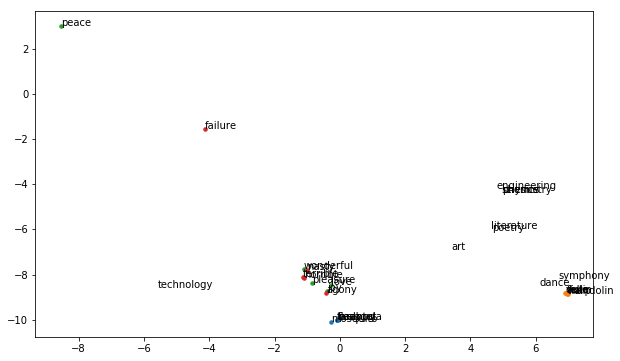

In [269]:
fig, ax = plt.subplots(figsize=(10,6))
k = len(my_words)

for i in range(num_cats):
    ax.scatter(Y[i*5:(i+1)*5, 0], Y[i*5:(i+1)*5, 1], c="C" + str(i), s=12)

for i, txt in enumerate(my_words):
    ax.annotate(txt, (Y[i,0],Y[i,1]), fontsize=10)
    
# plt.xlim((2,6))
# plt.ylim((-1,1))

Need to adjust xlim and ylim to zoom in on the crowded places.

# End